<a href="https://colab.research.google.com/github/Tecnologias-multimedia/InterCom/blob/master/docs/2-hours_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Enable horizontal scroll in shell outputs
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# [InterCom](https://github.com/Tecnologias-multimedia/intercom): a [Real-Time](https://en.wikipedia.org/wiki/Real-time) [Digital Audio](https://en.wikipedia.org/wiki/Digital_audio) [Full-Duplex](https://en.wikipedia.org/wiki/Duplex_(telecommunications)#FULL-DUPLEX) [Transmitter/Receiver](https://en.wikipedia.org/w/index.php?title=Data_transmission&redirect=no)

* InterCom is a [full-duplex](https://en.wikipedia.org/wiki/Duplex_(telecommunications)#FULL-DUPLEX) real-time [intercommunicator](https://en.wikipedia.org/wiki/Intercom) for digital ([PCM](https://en.wikipedia.org/wiki/Pulse-code_modulation)) [stereo](https://en.wikipedia.org/wiki/Stereophonic_sound) [audio](https://en.wikipedia.org/wiki/Digital_audio), that uses [the Internet](https://en.wikipedia.org/wiki/Internet).
* Is a project developed in the subject [Tecnologías Multimedia](https://tecnologias-multimedia.github.io/) at the [UAL](https://www.ual.es/estudios/grados/presentacion/plandeestudios/asignatura/4015/40154321).

## Contents

1. [`minimal.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/minimal.py): PCM audio transmission over UDP.
2. [`buffer.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/buffer.py): Hiding the jitter of the network.
3. [`BR_control_conservative.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/BR_control_conservative.py): Bit-rate control through quantization.
4. [`stereo_MST_coding_16.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/stereo_MST_coding_16.py): Removing intra-frame (spatial) redundancy.
5. [`temporal_overlapped_DWT_coding.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/temporal_overlapped_DWT_coding.py): Removing intra-channel (temporal) redundancy.
6. [`basic_ToH.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/basic_ToH.py): Perceptual coding using the threshold of hearing.


## 1. [`minimal.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/minimal.py)

Default configuration:

* Record chunks of audio (1024 samples/chunk) at a [sampling rate](https://en.wikipedia.org/wiki/Sampling_(signal_processing)) of 44100 samples/second.
* Send the chunks using [UDP](https://en.wikipedia.org/wiki/User_Datagram_Protocol).

        +-------------------------+                    +-------------------------+
        | Localhost               |                    | Localhost               |
        |  +----------+           |                    |           +----------+  |
        |  | InterCom |    +------+    +----------+    +------+    | InterCom |  |
        |  | process  |<-->| 4444 |<-->| Internet |<-->| 4444 |<-->| process  |  |
        |  +----------+    +------+    +----------+    +------+    +----------+  |
        |                         |                    |                         |
        +-------------------------+                    +-------------------------+


<p style="padding: 10px; border: 2px solid blue;"><font color='red'>Before running the next cell, please, check that the mic(rophone) and the speakers gains are not too high!</font><p>

In [ ]:
# Run this cell if you have a mic
!python ../src/minimal.py --show_stats -t 4

In [2]:
# Run this cell if the mic does not work
!python ../src/minimal.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename='../data/AviadorDro_LaZonaFantasma.oga', reading_time=5, number_of_channels=2, show_stats=True, show_samples=False, show_spectrum=False)

Using device:

   0 HDA NVidia: HDMI 0 (hw:0,3), ALSA (0 in, 2 out)
   1 HDA NVidia: HDMI 1 (hw:

## Internet usage (example)

To be tried at home.

           Local (NAT-ed) network A      Internet      Local (NAT-ed) network B
        =============================== ========== ===============================

             Host A            NAT_A                   NAT B           Host B
        +-------------+    +----------+            +----------+    +-------------+
        | InterCom    |    |          |            |          |    |    InterCom |
        | process     |<-->|     4444 |<-- .... -->| 4444     |<-->|     process |
        |        4444 |    |          |            |          |    | 4444        |
        +-------------+    +----------+            +----------+    +-------------+


        Host A> python minimal.py --destination_address NAT_B_public_IP_address
        Host B> python minimal.py --destination_address NAT_A_public_IP_address

## 2. [buffer.py](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/buffer.py)

Hidding the [packet jitter](https://en.wikipedia.org/wiki/Packet_delay_variation):

![With and without buffering](https://tecnologias-multimedia.github.io/contents/jitter/graphics/timelines.svg)

In [3]:
!ping localhost

PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.029 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=0.036 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=0.031 ms
64 bytes from localhost (127.0.0.1): icmp_seq=4 ttl=64 time=0.032 ms
^C

--- localhost ping statistics ---
4 packets transmitted, 4 received, 0% packet loss, time 3077ms
rtt min/avg/max/mdev = 0.029/0.032/0.036/0.002 ms


### Increase the jitter for the `localhost` link (only Linux)
* Using [`tc`](https://man7.org/linux/man-pages/man8/tc.8.html) (Traffic Control).
* Example with:
    * Average latency = 300 ms (average RTT = 600 ms).
    * Average `mdev` = 50 ms.
    * [Perarson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between delays = 0.25 (1.0 means total [correlation](https://en.wikipedia.org/wiki/Correlation) between consecutive simulations of the network delay/loss, 0.0 implies no correlation).
    * Statistical distribution of the RTTs = [normal](https://en.wikipedia.org/wiki/Normal_distribution).

<p style="padding: 10px; border: 2px solid blue;"><font color='red'>Please, before running the next cells, be sure that sudo does NOT request a password (open a terminal and run, for example, `sudo ls`). If a password is required, add the line `your_username ALL=(ALL) NOPASSWD: ALL` at the end of the `/etc/sudoers` file.</font><p>

<p style="padding: 10px; border: 2px solid blue;"><font color='red'>You must be aware that the modification of the latency/throughput of the `localhost` adapter affect also to the refresing time of this notebook! Please, be patient.</font><p>

In [4]:
# Influence in ping
avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

# Activate tc rules
!sudo tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}

# Show rules
!sudo tc qdisc show dev lo

# See the effect
!ping -c 3 localhost

# Remove rules
!sudo tc qdisc del dev lo root
!sudo tc qdisc show dev lo

# See the effect
!ping -c 3 localhost

qdisc noqueue 0: root refcnt 2 
qdisc netem 1: root refcnt 2 limit 1000 delay 300ms  50ms 25%
PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=652 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=552 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=554 ms

--- localhost ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 1999ms
rtt min/avg/max/mdev = 552.145/586.136/651.880/46.496 ms
qdisc noqueue 0: root refcnt 2 
PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=0.032 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=0.058 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=0.067 ms

--- localhost ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2073ms
rtt min/avg/max/mdev = 0.032/0.052/0.067/0.014 ms


### Let's listen again to minimal ...
... using a high jitter.

In [5]:
# Real machine

avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

!sudo tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc show dev lo

#!python ../src/minimal.py --show_stats -t 5  # If you want to listen to yourself
!python ../src/minimal.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

!sudo tc qdisc del dev lo root
!sudo tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 
qdisc netem 1: root refcnt 2 limit 1000 delay 300ms  50ms 25%
pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port=4444, filename='../data/AviadorDro_LaZonaFantasma.oga', reading_time=5, number_of_channels=2, show_stats=True, show_samples=False, show_spectrum=False)

Us

### Quite bad :-/ The chunks are not arriving with a constant cadence to the receiver

### Let's hidden the jitter
* The default buffering time in InterCom is 150 ms (see `buffer.py -h`).

In [6]:
avg_latency = 300
mean_deviation = 50
correlation = 25
distribution = "normal"

!sudo tc qdisc show dev lo
!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc show dev lo

!ping -c 3 localhost

#!python ../src/buffer.py --show_stats -t 5
!python ../src/buffer.py --show_stats -B 150 -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

# Remove rules
!sudo tc qdisc del dev lo root
!sudo tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 
qdisc netem 1: root refcnt 2 limit 1000 delay 300ms  50ms 25%
PING localhost (127.0.0.1) 56(84) bytes of data.
64 bytes from localhost (127.0.0.1): icmp_seq=1 ttl=64 time=612 ms
64 bytes from localhost (127.0.0.1): icmp_seq=2 ttl=64 time=672 ms
64 bytes from localhost (127.0.0.1): icmp_seq=3 ttl=64 time=567 ms

--- localhost ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2002ms
rtt min/avg/max/mdev = 567.047/617.163/672.482/43.200 ms
pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(I

### Much better!

## 3. [BR_control_conservative.py](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/BR_control_conservative.py)

* Audio data compression with [DEFLATE](https://en.wikipedia.org/wiki/DEFLATE) [entropy codec](https://en.wikipedia.org/wiki/Entropy_coding).
* "Conservative" [bit-rate](https://en.wikipedia.org/wiki/Bit_rate) control ...

  \begin{equation}
    \left\{
    \begin{array}{ll}
      \Delta = 2\Delta & \quad\text{if}~L>2, \\
      \Delta = \frac{10}{11}\Delta & \quad\text{always}, \\
      \Delta = \Delta_{\text{min}} & \quad\text{if}~\Delta < \Delta_{\text{min}}.
    \end{array}
    \right.
  \end{equation}

* ... through control of the [quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)) step size $\Delta$ ($L$ = number of lost chunks in the last second).

![Scalar quantization with deadzone](https://vicente-gonzalez-ruiz.github.io/scalar_quantization/docs/graphics/deadzone.svg)


### Effect of limiting the transmission bit-rate using `tc` (only Linux)
Configuration:
* Troughput $\approx$ 200 KBPS.
* PCM audio CD quality $\approx$ 1400 KBPS.

In [7]:
avg_latency = 10
mean_deviation = 10
correlation = 50
distribution = "normal"
throughput = 300 # KBPS

!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate {throughput}kbit burst 64kbit limit 64kbit

!python ../src/buffer.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!sudo tc qdisc show dev lo

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input

InterCom parameters:

Namespace(input_device=None, output_device=None, list_devices=False, frames_per_second=44100, frames_per_chunk=1024, listening_port=4444, destination_address='localhost', destination_port

### Effect of limiting the bit-rate, but using a bit-rate control algorithm

In [8]:
# (only Linux)

avg_latency = 10
mean_deviation = 10
correlation = 50
distribution = "normal"
throughput = 300 # KBPS

!sudo tc qdisc add dev lo root handle 1: netem delay {avg_latency}ms {mean_deviation}ms {correlation}% distribution {distribution}
!sudo tc qdisc add dev lo parent 1:1 handle 10: tbf rate {throughput}kbit burst 64kbit limit 64kbit

!python ../src/BR_control_conservative.py --show_stats -t 5 -f ../data/AviadorDro_LaZonaFantasma.oga

!sudo tc qdisc del dev lo parent 1:1 handle 10:
!sudo tc qdisc del dev lo root
!sudo tc qdisc show dev lo

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-s

### Let's see the impact of quantization in the quality of the audio

In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np
import sounddevice as sd
from scipy import signal

In [10]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

In [11]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

In [12]:
x = np.linspace(-8, 8, 500) # Input samples
k2 = quantizer(x, quantization_step = 2)
y2 = dequantizer(k2, quantization_step = 2)
k3 = quantizer(x, quantization_step = 3)
y3 = dequantizer(k3, quantization_step = 3)

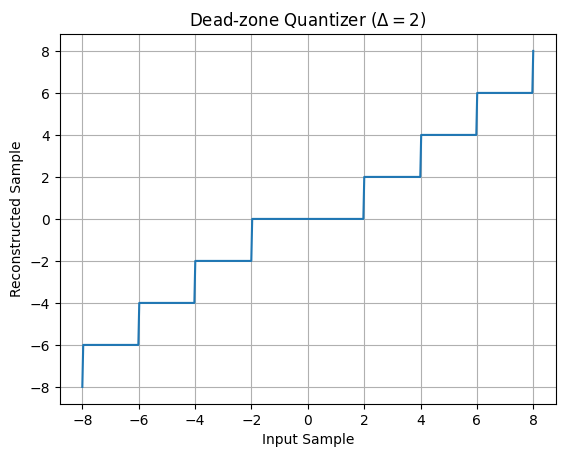

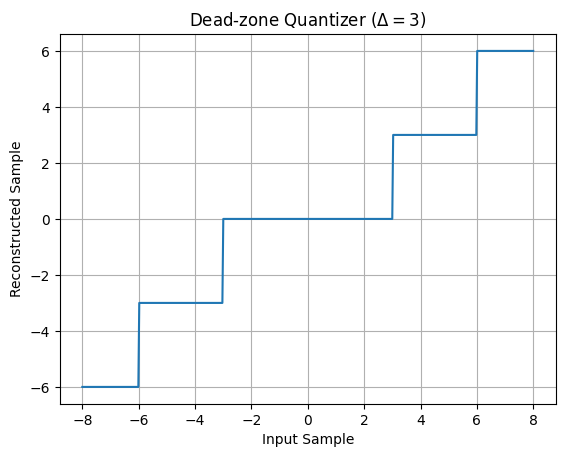

In [13]:
plot(x, y2, "Input Sample", r"Reconstructed Sample", r"Dead-zone Quantizer ($\Delta={}$)".format(2))
plot(x, y3, "Input Sample", r"Reconstructed Sample", r"Dead-zone Quantizer ($\Delta={}$)".format(3))

In [14]:
def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

In [15]:
x = np.arange(start = -8, stop = 9, step = 1)
k, y = q_deq(x, quantization_step = 3)
print("    Original samples =", x)
print("Quantization indexes =", k)
print(" Dequantized samples =", y)

    Original samples = [-8 -7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8]
Quantization indexes = [-2 -2 -2 -1 -1 -1  0  0  0  0  0  1  1  1  2  2  2]
 Dequantized samples = [-6 -6 -6 -3 -3 -3  0  0  0  0  0  3  3  3  6  6  6]


In [16]:
# Run this cell if you have a mic ... and want to use your own audio
sampling_rate = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * sampling_rate), samplerate=sampling_rate, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


In [17]:
# Run this cell if you don't have a mic
import soundfile
x, sampling_rate = soundfile.read("../data/AviadorDro_LaZonaFantasma.oga")
x = x[0:65536*2] * 32768
x = x.astype(np.int16)

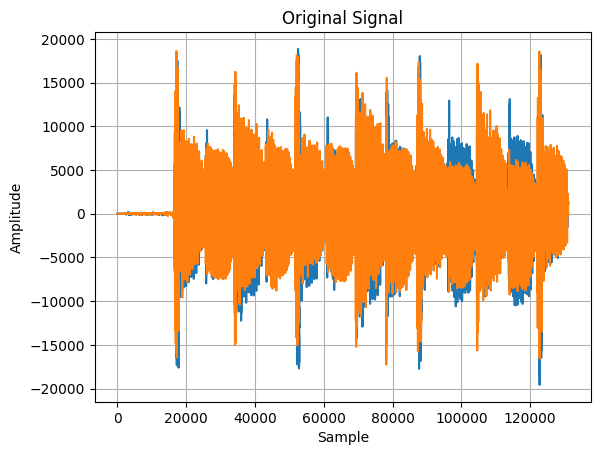

In [18]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Sample", "Amplitude", "Original Signal")

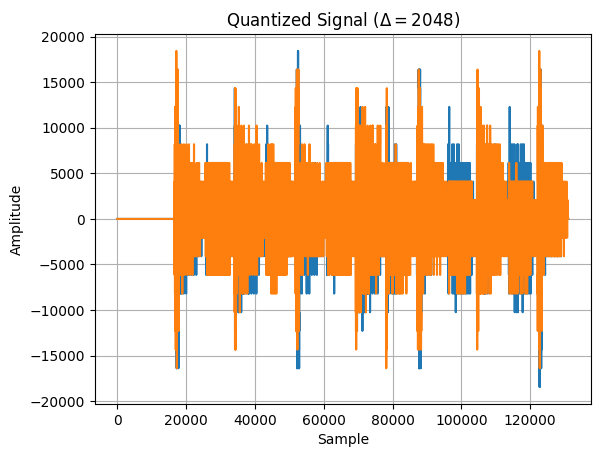

In [19]:
# Effect of quantization
quantization_step = 2048
k, y = q_deq(x, quantization_step)
sd.play(y)
plot(np.linspace(0, len(y)-1, len(y)), y, "Sample", "Amplitude", r"Quantized Signal ($\Delta={}$)".format(quantization_step))

In [20]:
# RD curve

def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def RD_curve(x):
    points = []
    for q_step in range(128, 4096, 128):
        k, y = q_deq(x, q_step)
        #print(np.unique(k))
        rate = entropy_in_bits_per_symbol(k)
        distortion = RMSE(x, y)
        points.append((rate, distortion))
    return points

In [21]:
RD_points = RD_curve(x)

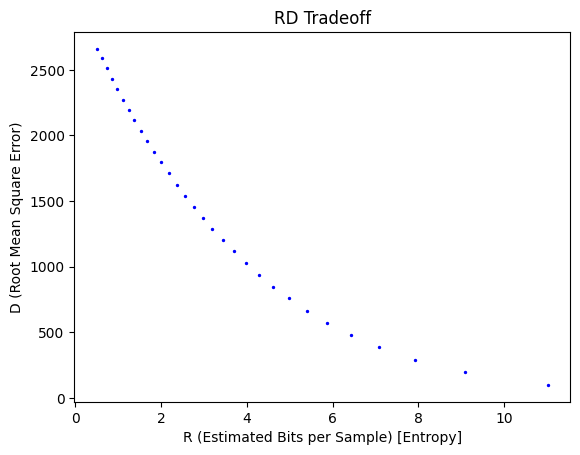

In [22]:
plt.title("RD Tradeoff")
plt.xlabel("R (Estimated Bits per Sample) [Entropy]")
plt.ylabel("D (Root Mean Square Error)")
plt.scatter(*zip(*RD_points), s=2, c='b', marker="o")
plt.show()

## 4. [`stereo_MST_coding_16.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/stereo_MST_coding_16.py)
* Removes intra-frame redundancy using the [MST (Mid/Side Transform)](https://en.wikipedia.org/wiki/Joint_encoding#M/S_stereo_coding).
* Forward transform:
\begin{equation}
  \mathbf{w} = \mathbf{K}\mathbf{x} = \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}\mathbf{x},
\end{equation}
* Inverse transform:
\begin{equation}
  \mathbf{x} = \mathbf{K}^{-1}\mathbf{w} = \frac{1}{2}\mathbf{K}^{\text T}\mathbf{w} = \frac{1}{2}\mathbf{K}\mathbf{w} = \frac{1}{2}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}\mathbf{w}.
\end{equation}
* $\mathbf{x}$ a frame, $\mathbf{w}_0$ the low-frequency coefficient (the average), and $\mathbf{w}_1$ the high-frequency coefficient (the difference).

In [23]:
def plot(y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, len(y))
    ax.plot(x, y, '.', markersize=1)
    plt.show(block=False)

In [24]:
# Run this cell if you have a mic
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


In [25]:
# Run this cell if you don't have a mic
import soundfile
x, sampling_rate = soundfile.read("../data/AviadorDro_LaZonaFantasma.oga")
x = x[0:65536*2] * 32768
x = x.astype(np.int16)

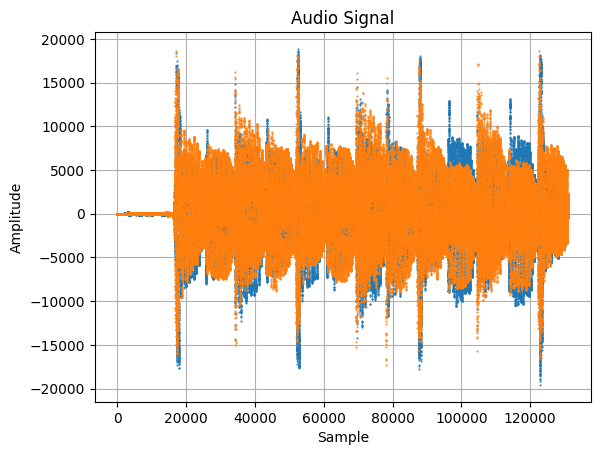

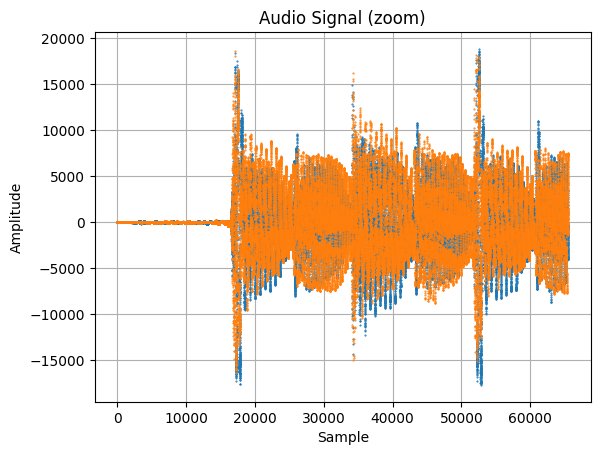

In [26]:
# Original
plot(x, "Sample", "Amplitude", "Audio Signal")
#x = x[65536:]
x = x[:65536] # The Dyadic DWT works better when the number of samples is a power of 2
plot(x, "Sample", "Amplitude", "Audio Signal (zoom)")
sd.play(x)

In [27]:
def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

In [28]:
w = MST_analyze(x)

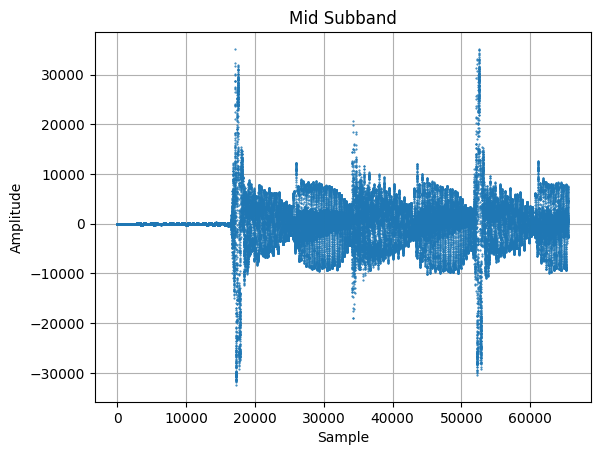

In [29]:
plot(w[:, 0], "Sample", "Amplitude", "Mid Subband")
sd.play(w[:, 0].astype(np.int16))

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


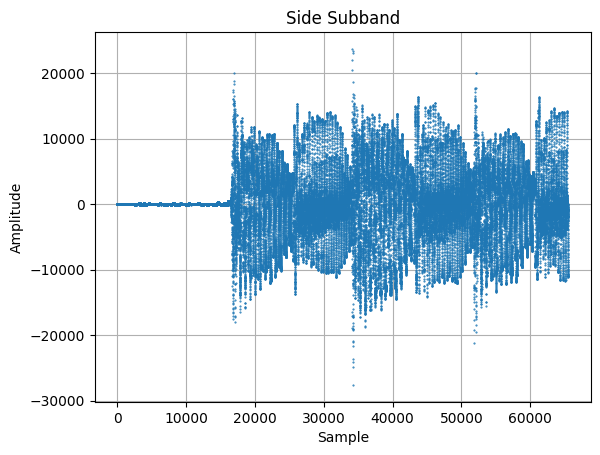

In [30]:
plot(w[:, 1], "Sample", "Amplitude", "Side Subband")
sd.play(w[:, 1].astype(np.int16))

### Frequency response of the filters

In [31]:
K1 = np.array([1.0, 1.0])
w1, h1 = signal.freqz(K1, fs=44100)
K2 = np.array([1.0, -1.0])
w2, h2 = signal.freqz(K2, fs=44100)

/tmp/ipykernel_2943291/1969458427.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w2, 20 * np.log10(abs(h2)), 'b')


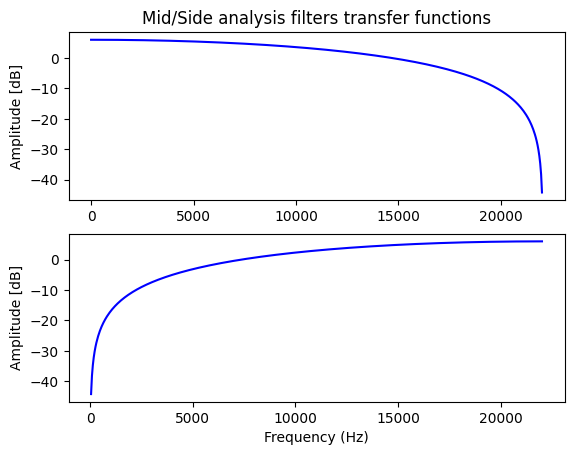

In [32]:
plt.subplot(211)
plt.title('Mid/Side analysis filters transfer functions')
plt.plot(w1, 20 * np.log10(abs(h1)), 'b')
plt.ylabel('Amplitude [dB]')
plt.subplot(212)
plt.plot(w2, 20 * np.log10(abs(h2)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude [dB]')
plt.show()

* Notice that the frequency response of the filters exhibit symmetry (one is the mirror of the other).

### Effect of quantization of the MST subbands

In [33]:
def quantizer(x, quantization_step):
    '''Deadzone quantization.'''
    k = (x / quantization_step).astype(np.int32)
    return k

def q_RD_curve(data):
    '''RD curve in the space domain.'''
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    return RD_points

def MST_RD_curve(data):
    '''RD curve in the MST domain.'''
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        reconstructed_data = MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

In [34]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)

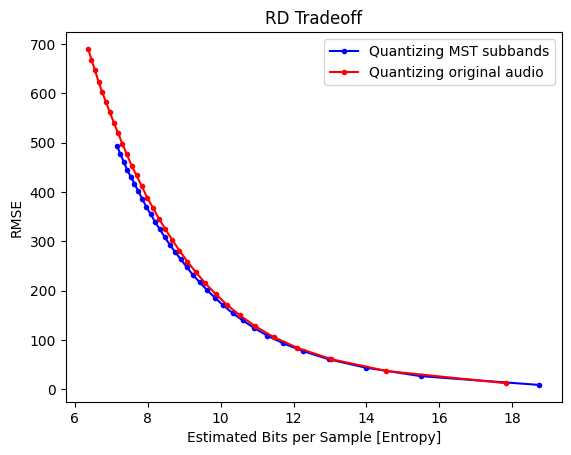

In [35]:
plt.title("RD Tradeoff")
plt.xlabel("Estimated Bits per Sample [Entropy]")
plt.ylabel("RMSE")
plt.plot(*zip(*MST_RD_points), c='b', marker=".", label='Quantizing MST subbands')
plt.plot(*zip(*q_RD_points), c='r', marker=".", label='Quantizing original audio')
plt.legend(loc='upper right')
plt.show()

### Perceptual impact of the MST

In [36]:
# Real machine (no mic is required)
!python ../src/stereo_MST_coding_16.py --show_stats -t 10 -f ../data/AviadorDro_LaZonaFantasma.oga

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-s

In [ ]:
!python ../src/BR_control_conservative.py --show_stats -t 10 -f ../data/AviadorDro_LaZonaFantasma.oga

## 5. [`temporal_overlapped_DWT_coding.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/temporal_overlapped_DWT_coding.py)
* [DWT](https://en.wikipedia.org/wiki/Discrete_wavelet_transform) removes temporal redundancy (the MST coefficients of a subband are correlated in time).
* Dyadic frequency decomposition using perfect reconstruction [filter banks](https://en.wikipedia.org/wiki/Filter_bank):
![DWT](https://tecnologias-multimedia.github.io/contents/transform_coding/graphics/cascade.svg)
* Example using [lifting](https://en.wikipedia.org/wiki/Lifting_scheme) ([Biorthogonal (2,2) of Cohen-Daubechies-
Feauveau](http://www.mat.unimi.it/users/naldi/lifting.pdf)):

\begin{equation}
  {\mathbf h}^l_i = {\mathbf l}^{l-1}_{2i+1} - \frac{1}{2}({\mathbf l}^{l-1}_{2i} + {\mathbf l}^{l-1}_{2i+2})
\end{equation}
\begin{equation}
  {\mathbf l}^l_i = {\mathbf l}^{l-1}_{2i} + \frac{1}{4}({\mathbf h}^l_{i-1} + {\mathbf h}^l_i),
\end{equation}

### Dyadic frequency decomposition:

In [37]:
def average_complex_energy(x):
    return np.sum(x.real.astype(np.double)*x.real.astype(np.double) +
                  x.imag.astype(np.double)*x.imag.astype(np.double))/len(x)

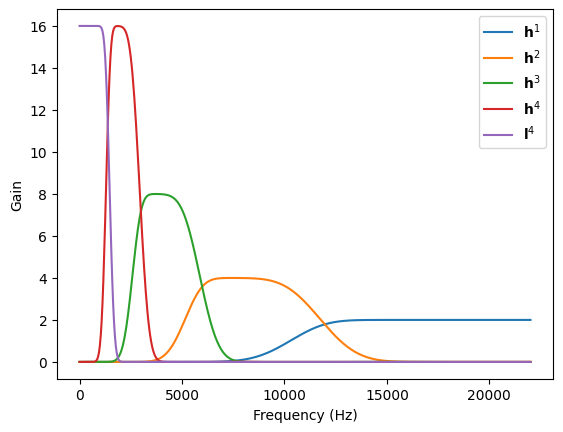

In [38]:
import pywt # pip install pywavelets
from IPython.display import Math

%matplotlib inline

#filters_name = "haar"
#filters_name = "db5"
#filters_name = "db7"
#filters_name = "db11"
filters_name = "db20"
#filters_name = "bior3.5"

wavelet = pywt.Wavelet(filters_name)

N_levels = 4

for l in range(N_levels):
    filters = wavelet.wavefun(level = (l+1))[:-1]
    w0, h0 = signal.freqz(filters[0], fs=44100)
    w1, h1 = signal.freqz(filters[1], fs=44100)
    plt.plot(w1, abs(h1), label=r"$\mathbf{h}" + rf"^{l+1}$")
    #display(Math("\\text{Average energy of}~" + r"\mathbf{h}" + f"^{l+1}" + f" = {average_complex_energy(h1)}"))
plt.plot(w0, abs(h0), label=r"$\mathbf{l}" + rf"^{l+1}$")
#display(Math("\\text{Average energy of}~" + r"\mathbf{l}" + f"^{l+1}" + f" = {average_complex_energy(h0)}"))
plt.legend(loc="best")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.show()

### DWT in action (only Linux)
Go to the shell and run (inside of the `test` folder):
```
python sounddevice/plot_input_stereo.py &
python transforms/rfft_hamming.py &
python transforms/dwt5.py &
python sounddevice/play_sine.py 440
```

### DWT RD performance

In [39]:
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def DWT_analyze(x, levels):
    coefs = np.empty(x.shape, dtype=np.int32)
    decomposition_0 = pywt.wavedec(x[:, 0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(x[:, 1], wavelet=wavelet, level=levels, mode="per")
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int32)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int32)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int32)
    return samples

def DWT_RD_curve(data, levels):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(data)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        k, y = q_deq(DWT_coefs, q_step)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        MST_coefs = DWT_synthesize(y, slices)
        reconstructed_data = MST_synthesize(MST_coefs)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    return RD_points

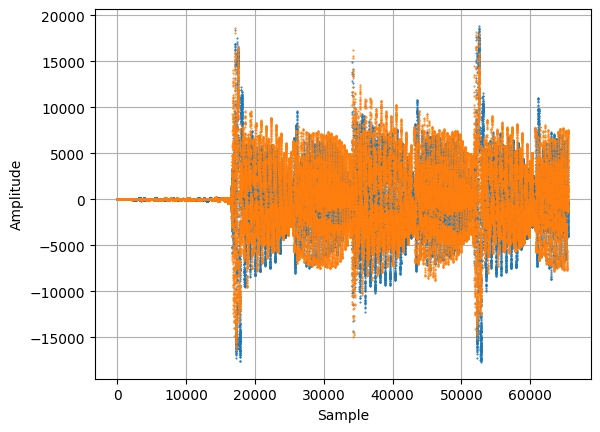

In [40]:
x = x[:65536]
plot(x, "Sample", "Amplitude", "")
sd.play(x.astype(np.int16))

In [41]:
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)
DWT_RD_points = DWT_RD_curve(x, levels = N_levels)

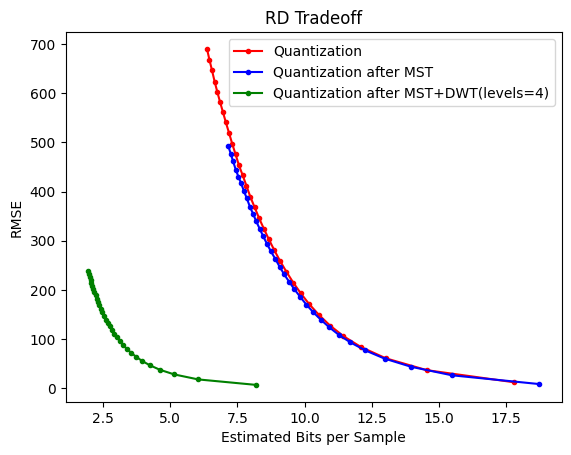

In [42]:
plt.title("RD Tradeoff")
plt.xlabel("Estimated Bits per Sample")
plt.ylabel("RMSE")
plt.plot(*zip(*q_RD_points), c='r', marker=".", label='Quantization')
plt.plot(*zip(*MST_RD_points), c='b', marker=".", label='Quantization after MST')
plt.plot(*zip(*DWT_RD_points), c='g', marker=".", label=f'Quantization after MST+DWT(levels={N_levels})')
plt.legend(loc='upper right')
plt.show()

### Perceptual gain of the temporal decorrelation

In [43]:
!python ../src/temporal_overlapped_DWT_coding.py --show_stats -t 10 -f ../data/AviadorDro_LaZonaFantasma.oga

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-s

## 6. [`basic_ToH.py`](https://github.com/Tecnologias-multimedia/InterCom/blob/master/src/basic_ToH.py)
[Perceptual](https://en.wikipedia.org/wiki/Psychoacoustics) coding using the [threshold of hearing](https://en.wikipedia.org/wiki/Absolute_threshold_of_hearing).

### Frequency resolution provided by the (Dyadic) DWT vs the [Threshold of (Human) Hearing (ToH)](https://tecnologias-multimedia.github.io/study_guide/threshold_of_hearing/)

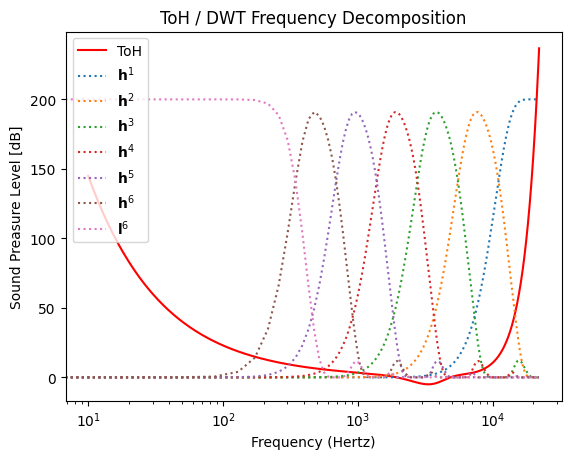

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy import signal

x = np.linspace(10,22050,22050)
y = 3.64*(x/1000)**(-0.8) - 6.5*np.exp((-0.6)*(x/1000-3.3)**2) + 1E-3*(x/1000)**4
plt.xscale("log")
plt.yscale("linear")
plt.title("ToH / DWT Frequency Decomposition")
plt.xlabel("Frequency (Hertz)")
plt.ylabel("Sound Preasure Level [dB]")
plt.plot(x, y, c='r', label="ToH")

wavelet = pywt.Wavelet("db5")

N_levels = 6

for l in range(N_levels):
    filters = wavelet.wavefun(level = (l+1))[:-1]
    w0, h0 = signal.freqz(filters[0], fs=44100)
    w1, h1 = signal.freqz(filters[1], fs=44100)
    plt.plot(w1, 100*abs(h1)/2**l, label="$\\mathbf{h}$" + f"$^{l+1}$", linestyle="dotted")
plt.plot(w0, 100*abs(h0)/2**(N_levels-1), label="$\\mathbf{l}$" + f"$^{l+1}$", linestyle="dotted")

plt.legend(loc='best')

plt.show()

* The QSSs are adapted to the ToH in each DWT subband.

### Effect of using the ToH

#### Without using the ToH

In [45]:
!python ../src/temporal_overlapped_DWT_coding.py -q 3000 --show_stats -t 10 -f ../data/AviadorDro_LaZonaFantasma.oga

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-s

In [46]:
!python ../src/basic_ToH.py -q 1024 --show_stats -t 10 -f ../data/AviadorDro_LaZonaFantasma.oga

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) minimal: seconds_per_cycle = 1
(INFO) minimal: chunks_per_cycle = 43.06640625
(INFO) minimal: frames_per_cycle = 44100
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Using "../data/AviadorDro_LaZonaFantasma.oga" as input
(INFO) DEFLATE_raw: Compress each raw chunk using DEFLATE.
(INFO) DEFLATE_byteplanes3: Compress the least significant byte planes of the chunks using DEFLATE. The channels are consecutive (serialized). 3 code-s

## 7. Currently working on ...
1. [Increase the number of subbands to map better the ToH](https://tecnologias-multimedia.github.io/contents/threshold_of_hearing/).
2. [Consider the simultaneous masking effect](https://tecnologias-multimedia.github.io/contents/simultaneous_masking/).
3. [Echo cancellation](https://tecnologias-multimedia.github.io/contents/echo_cancellation/).
4. ... and some day ... [Video](https://en.wikipedia.org/wiki/Video)!

## Appendix

### Resumen

La transmisión en tiempo real de señales sobre redes de datos no dedicadas plantea problemas de latencia y de rendimiento. En este seminario se analizan las principales técnicas usadas para mitigar dichos problemas, y se evalúa su efectividad en InterCom (https://github.com/Tecnologias-multimedia/InterCom), una aplicación que permite la intercomunicación (mediante señales de audio) entre 2 usuarios conectados a Internet. Más información en https://github.com/Tecnologias-multimedia/InterCom/blob/master/docs/2-hours_seminar.ipynb.

The real-time transmission of signals over non-dedicated data networks generates latency and performance issues. In this seminar, the main techniques used to mitigate these problems are analyzed, and their effectiveness is evaluated in InterCom (https://github.com/Tecnologias-multimedia/InterCom), an application that allows intercommunication (through audio signals) between 2 users connected to the Internet. More information at https://github.com/Tecnologias-multimedia/InterCom/blob/master/docs/2-hours_seminar.ipynb.